# Visualize Amazon Customer Reviews Dataset

# Dataset Column Descriptions

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [29]:
!pip install -q pandas==0.23.0
!pip install -q numpy==1.14.3
!pip install -q matplotlib==3.0.3
!pip install -q seaborn==0.8.1
!pip install -q PyAthena==1.8.0

ERROR: tensorflow 2.1.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.3 which is incompatible.
ERROR: smdebug 0.8.0 has requirement numpy<2.0.0,>1.16.0, but you'll have numpy 1.14.3 which is incompatible.


In [30]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [31]:
# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Set Athena database & table 
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'

In [32]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [33]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

# Set Seaborn Parameters

In [34]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

# Helper Code to Display Values on Bars

In [35]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# 1. Which Product Categories are Highest Rated by Average Rating?

In [36]:
# SQL statement
statement = """
SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM {}.{} 
GROUP BY product_category 
ORDER BY avg_star_rating DESC
""".format(database_name, table_name)

print(statement)


SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM dsoaws.amazon_reviews_parquet 
GROUP BY product_category 
ORDER BY avg_star_rating DESC



In [37]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,avg_star_rating
0,Gift Card,4.731363
1,Digital_Music_Purchase,4.642891
2,Music,4.436624
3,Books,4.341658
4,Grocery,4.312219
5,Digital_Ebook_Purchase,4.308775
6,Video DVD,4.302017
7,Tools,4.261769
8,Musical Instruments,4.251103
9,Automotive,4.246302


In [38]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
average_star_ratings = df

43


## Visualization for a Subset of Product Categories

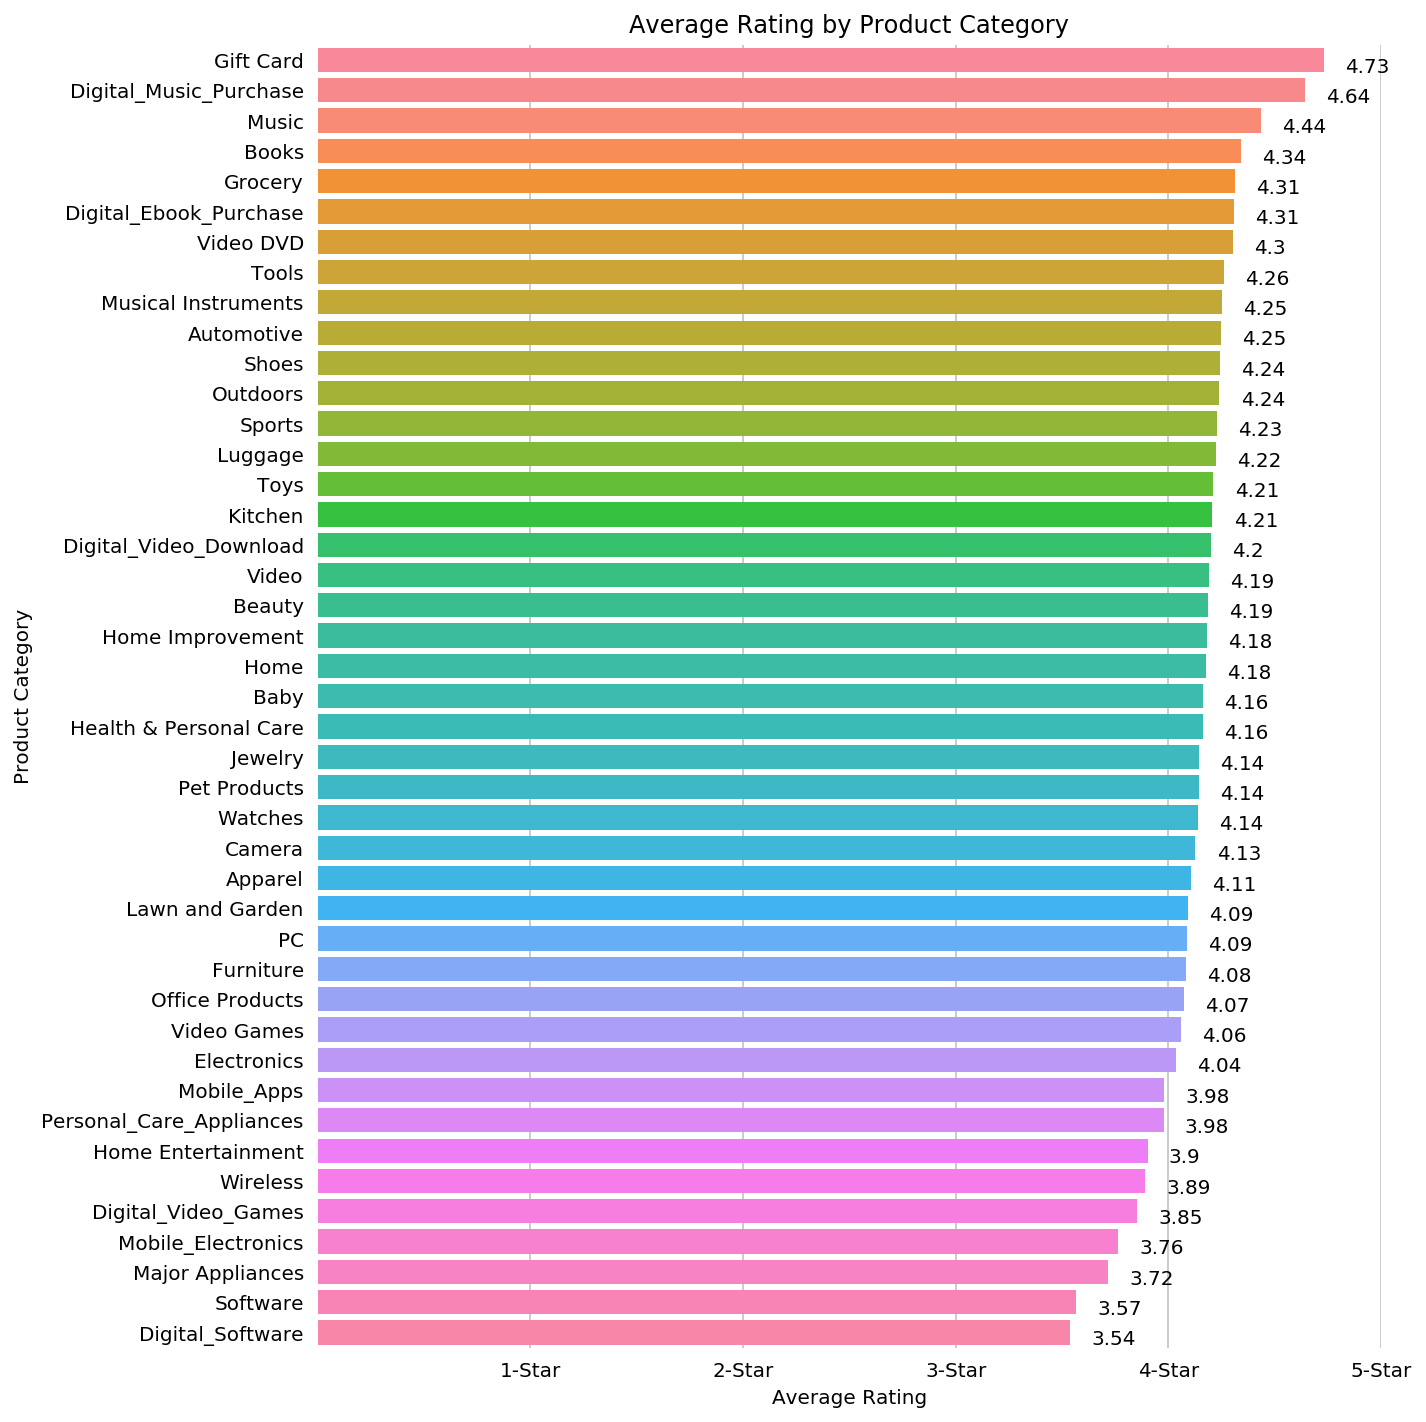

In [39]:
# Create plot
barplot = sns.barplot(y='product_category', x='avg_star_rating', data = df, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 5.0)})
    
# Set title and x-axis ticks 
plt.title('Average Rating by Product Category')
plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-01.png"  width="80%" align="left">

# 2. Which Product Categories Have the Most Reviews?

In [40]:
# SQL statement
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM {}.{}
GROUP BY product_category 
ORDER BY count_star_rating DESC
""".format(database_name, table_name)

print(statement)


SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category 
ORDER BY count_star_rating DESC



In [41]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,count_star_rating
0,Books,19531329
1,Digital_Ebook_Purchase,17622415
2,Wireless,9002021
3,PC,6908554
4,Home,6221559
5,Apparel,5906333
6,Health & Personal Care,5331449
7,Beauty,5115666
8,Video DVD,5069140
9,Mobile_Apps,5033376


In [42]:
# Store counts
count_ratings = df['count_star_rating']

# Store max ratings
max_ratings = df['count_star_rating'].max()
print(max_ratings)

19531329


## Visualization for a Subset of Product Categories

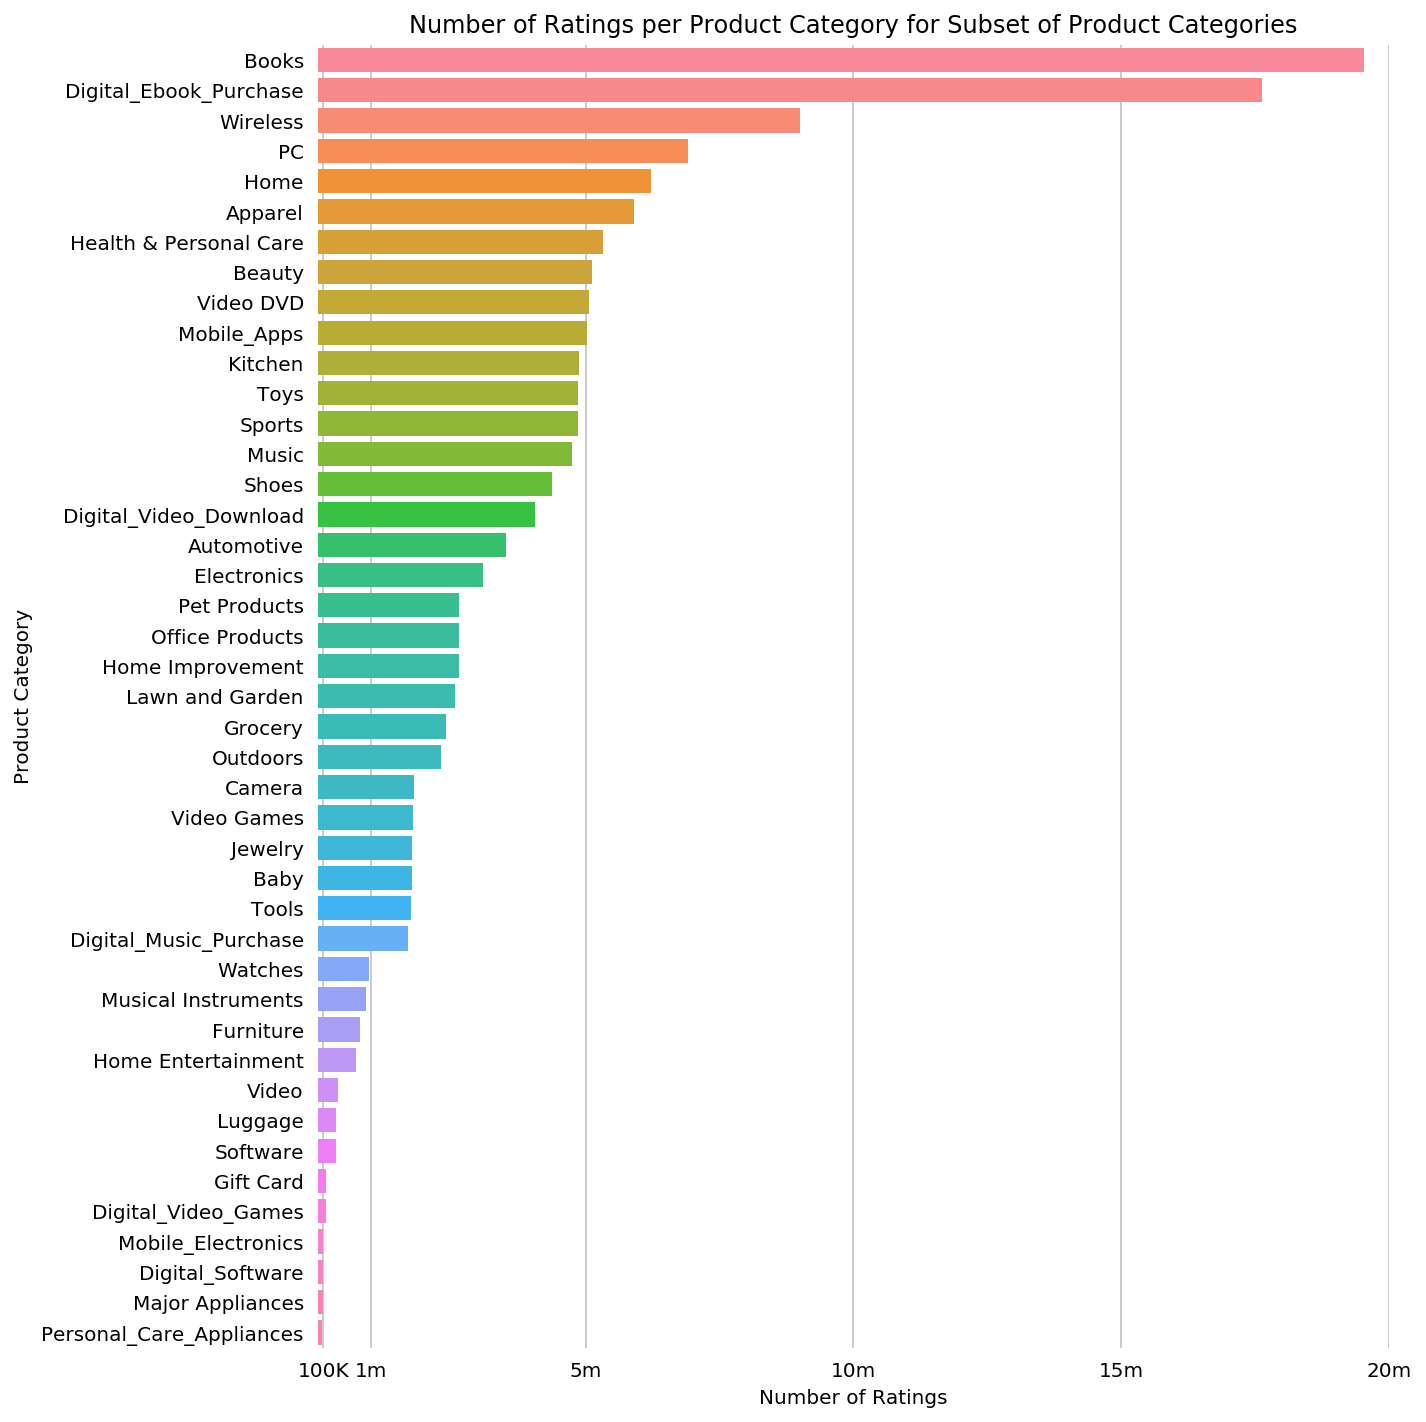

In [43]:
# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale 
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-02.png"  width="80%" align="left">

# 3. When did each product category become available in the Amazon catalog based on the date of the first review?

In [44]:
# SQL statement 
statement = """
SELECT product_category, MIN(review_date) AS first_review_date
FROM {}.{}
GROUP BY product_category
ORDER BY first_review_date 
""".format(database_name, table_name)

print(statement)


SELECT product_category, MIN(review_date) AS first_review_date
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category
ORDER BY first_review_date 



In [45]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,first_review_date
0,Books,9305
1,Video,9445
2,Music,9445
3,Video DVD,9685
4,Toys,9866
5,Sports,10143
6,Video Games,10171
7,Home,10375
8,Office Products,10422
9,Pet Products,10461


In [46]:
# Convert date strings (e.g. 2014-10-18) to datetime
import datetime as datetime
dates = pd.to_datetime(df['first_review_date'])


In [47]:
# See: https://stackoverflow.com/questions/60761410/how-to-graph-events-on-a-timeline

def modify_dataframe(df):
    """ Modify dataframe to include new columns """
    df['year'] = pd.to_datetime(df['first_review_date'], format='%Y-%m-%d').dt.year
    return df

def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df['year'].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values


In [48]:
new_df = modify_dataframe(df)
print(new_df)

X, Y = get_x_y(new_df)

            product_category  first_review_date  year
0                      Books               9305  1970
1                      Video               9445  1970
2                      Music               9445  1970
3                  Video DVD               9685  1970
4                       Toys               9866  1970
5                     Sports              10143  1970
6                Video Games              10171  1970
7                       Home              10375  1970
8            Office Products              10422  1970
9               Pet Products              10461  1970
10                  Software              10490  1970
11        Home Entertainment              10514  1970
12                    Camera              10550  1970
13                  Wireless              10564  1970
14    Health & Personal Care              10628  1970
15                  Outdoors              10674  1970
16               Electronics              10751  1970
17                        PC

## Visualization for a Subset of Product Categories

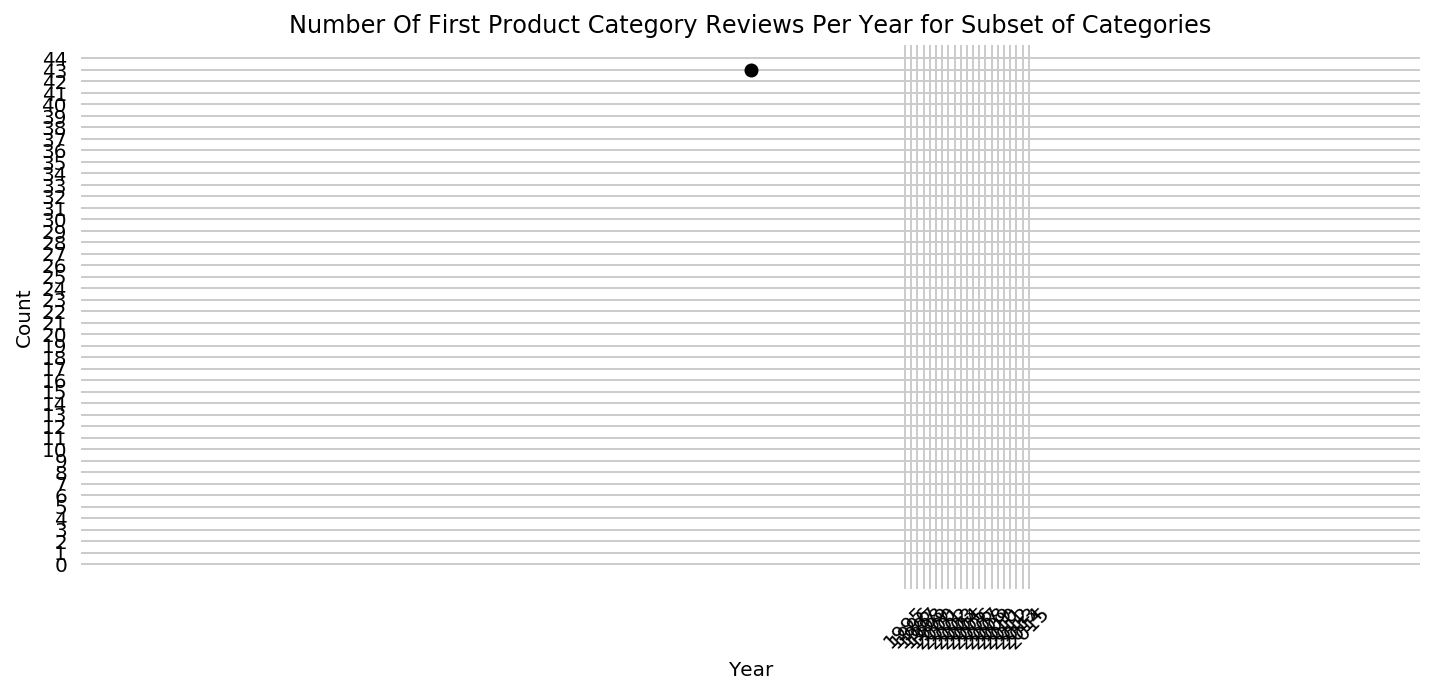

In [49]:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()

ax.set_title('Number Of First Product Category Reviews Per Year for Subset of Categories')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0]*len(X), Y, facecolor='lightblue')

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y)+2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-04.png"  width="90%" align="left">

# 4. What is the breakdown of ratings (1-5) per product category?  


In [50]:
# SQL statement 
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [51]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,star_rating,count_reviews
0,Apparel,5,3320566
1,Apparel,4,1147237
2,Apparel,3,623471
3,Apparel,2,369601
4,Apparel,1,445458
5,Automotive,5,2300757
6,Automotive,4,526665
7,Automotive,3,239886
8,Automotive,2,147767
9,Automotive,1,299867


## Prepare for Stacked Percentage Horizontal Bar Plot Showing Proportion of Star Ratings per Product Category

In [52]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby('product_category')
grouped_star = df.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df.groupby(['star_rating']).sum()

# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

150962278


In [53]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.get_value(i, 'count_reviews'))
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)


{'Apparel': [3320566, 1147237, 623471, 369601, 445458], 'Automotive': [2300757, 526665, 239886, 147767, 299867], 'Baby': [1070258, 287370, 149935, 100956, 144413], 'Beauty': [3254909, 741434, 398402, 264029, 456892], 'Books': [12874022, 3352504, 1452686, 808056, 1044061], 'Camera': [1062707, 336701, 141460, 90949, 170157], 'Digital_Ebook_Purchase': [10632313, 3983850, 1568686, 690426, 747140], 'Digital_Music_Purchase': [1345149, 207333, 62404, 25018, 48980], 'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Download': [2446375, 767302, 350900, 198566, 294004], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Electronics': [1781161, 536821, 238587, 179180, 358120], 'Furniture': [447716, 153666, 73563, 43848, 73320], 'Gift Card': [129709, 9859, 3156, 1569, 4793], 'Grocery': [1662261, 293389, 161495, 105265, 180048], 'Health & Personal Care': [3358258, 781760, 400428, 277981, 513022], 'Home': [3893005, 959228, 500416, 324062, 544848], 'Home Entertainment': [

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [54]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift Card', 'Grocery', 'Health & Personal Care', 'Home', 'Home Entertainment', 'Home Improvement', 'Jewelry', 'Kitchen', 'Lawn and Garden', 'Luggage', 'Major Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical Instruments', 'Office Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video DVD', 'Video Games', 'Watches', 'Wireless'])


In [55]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Apparel', [3320566, 1147237, 623471, 369601, 445458]), ('Automotive', [2300757, 526665, 239886, 147767, 299867]), ('Baby', [1070258, 287370, 149935, 100956, 144413]), ('Beauty', [3254909, 741434, 398402, 264029, 456892]), ('Books', [12874022, 3352504, 1452686, 808056, 1044061]), ('Camera', [1062707, 336701, 141460, 90949, 170157]), ('Digital_Ebook_Purchase', [10632313, 3983850, 1568686, 690426, 747140]), ('Digital_Music_Purchase', [1345149, 207333, 62404, 25018, 48980]), ('Digital_Software', [46410, 16693, 8308, 6890, 23783]), ('Digital_Video_Download', [2446375, 767302, 350900, 198566, 294004]), ('Digital_Video_Games', [80677, 20406, 11629, 7749, 24970]), ('Electronics', [1781161, 536821, 238587, 179180, 358120]), ('Furniture', [447716, 153666, 73563, 43848, 73320]), ('Gift Card', [129709, 9859, 3156, 1569, 4793]), ('Grocery', [1662261, 293389, 161495, 105265, 180048]), ('Health & Personal Care', [3358258, 781760, 400428, 277981, 513022]), ('Home', [3893005, 959228, 5004

### Build Array per Star Across All Categories

In [56]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:,0]
for index, value in average_star_ratings.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

In [57]:
sorted_distribution

{'Gift Card': [129709, 9859, 3156, 1569, 4793],
 'Digital_Music_Purchase': [1345149, 207333, 62404, 25018, 48980],
 'Music': [3290502, 796385, 311666, 154887, 198137],
 'Books': [12874022, 3352504, 1452686, 808056, 1044061],
 'Grocery': [1662261, 293389, 161495, 105265, 180048],
 'Digital_Ebook_Purchase': [10632313, 3983850, 1568686, 690426, 747140],
 'Video DVD': [3329987, 811766, 385875, 211390, 330122],
 'Tools': [1113566, 299318, 126028, 74792, 127396],
 'Musical Instruments': [572917, 158532, 67045, 40130, 66141],
 'Automotive': [2300757, 526665, 239886, 147767, 299867],
 'Shoes': [2639935, 847792, 404182, 242832, 232175],
 'Outdoors': [1434889, 417545, 179102, 109429, 161436],
 'Sports': [3040720, 836773, 380499, 229384, 362984],
 'Luggage': [216499, 61433, 27846, 17871, 25008],
 'Toys': [3076922, 769722, 387722, 230380, 399503],
 'Kitchen': [3128564, 732471, 349929, 242196, 427306],
 'Digital_Video_Download': [2446375, 767302, 350900, 198566, 294004],
 'Video': [227500, 72109, 3

In [58]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star5.append(stars[0])
    star4.append(stars[1])
    star3.append(stars[2])
    star2.append(stars[3])
    star1.append(stars[4])

## Visualization for a Subset of Product Categories

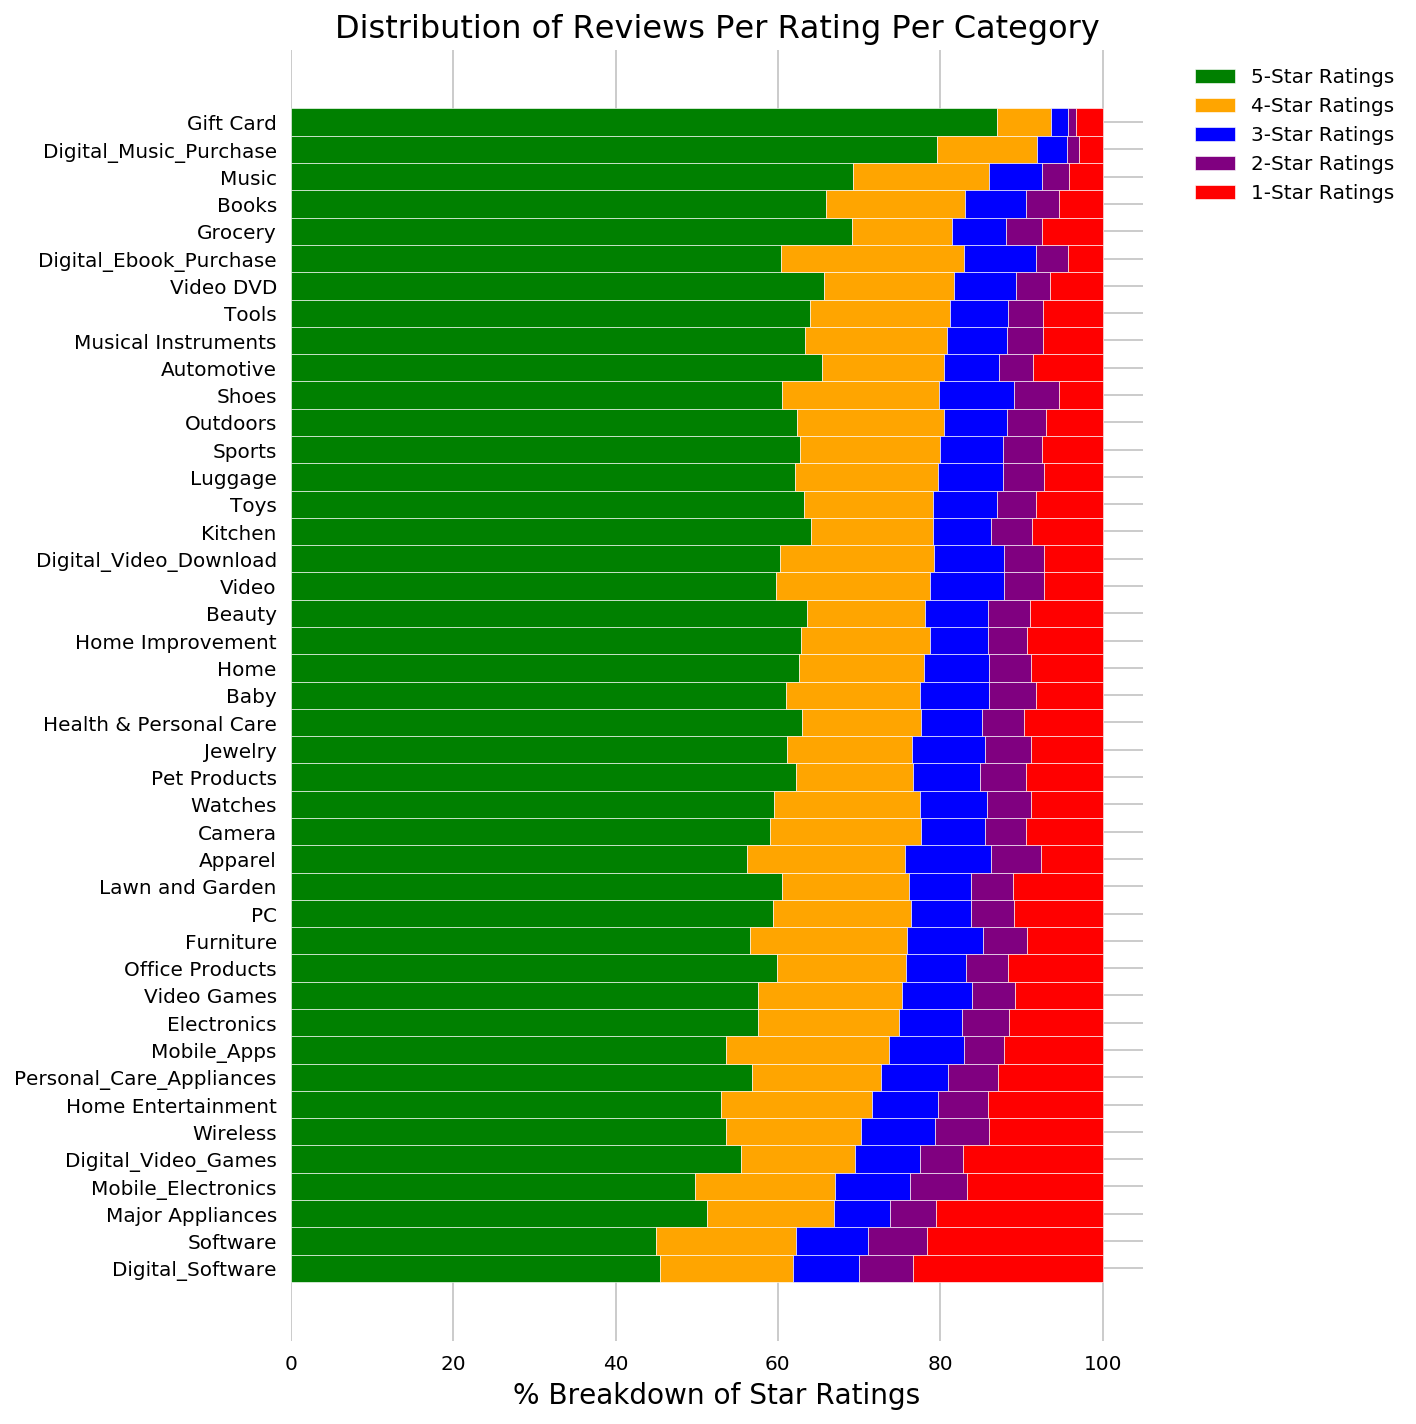

In [59]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='regular')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('proportion_star_per_category.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-05.png"  width="80%" align="left">

# 5. How Many Reviews per Star Rating? (5, 4, 3, 2, 1) 

In [82]:
# SQL statement 
statement = """
SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 
""".format(database_name, table_name)

print(statement)


SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 



In [83]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,star_rating,count_reviews
0,5,93200812
1,4,26223470
2,3,12133927
3,2,7304430
4,1,12099639


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_count_all.png"  width="25%" align="left">

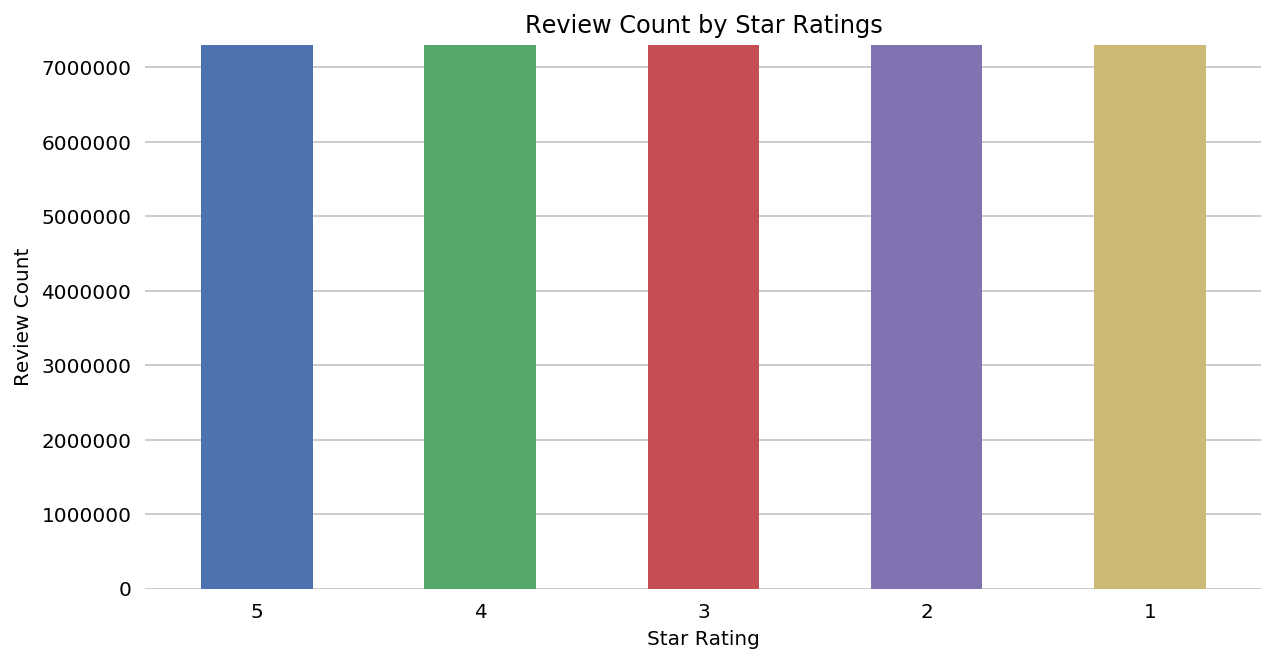

In [101]:
chart = df.plot.bar(x='star_rating', 
                    y='count_reviews', 
                    rot='0',
                    figsize=(10,5), 
                    title='Review Count by Star Ratings', 
                    legend=False )

plt.xlabel('Star Rating')
plt.ylabel('Review Count')
plt.ylim(top=7300000)

plt.show(chart)

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:


<img src="img/star_rating_count_all_bar_chart.png"  width="60%" align="left">

# 6. How Did Star Ratings Change Over Time?
Is there a drop-off point for certain product categories throughout the year?

## Average Star Rating Across All Product Categories

In [66]:
# SQL statement 
statement = """
SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM {}.{}
GROUP BY year
ORDER BY year
""".format(database_name, table_name)

print(statement)


SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM dsoaws.amazon_reviews_parquet
GROUP BY year
ORDER BY year



In [67]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,year,avg_rating
0,1995,4.6169
1,1996,4.6003
2,1997,4.4344
3,1998,4.3607
4,1999,4.2819
5,2000,4.2569
6,2001,4.1954
7,2002,4.1568
8,2003,4.1104
9,2004,4.0570


In [68]:
df['year'] = pd.to_datetime(df['year'], format='%Y').dt.year


## Visualization for a Subset of Product Categories

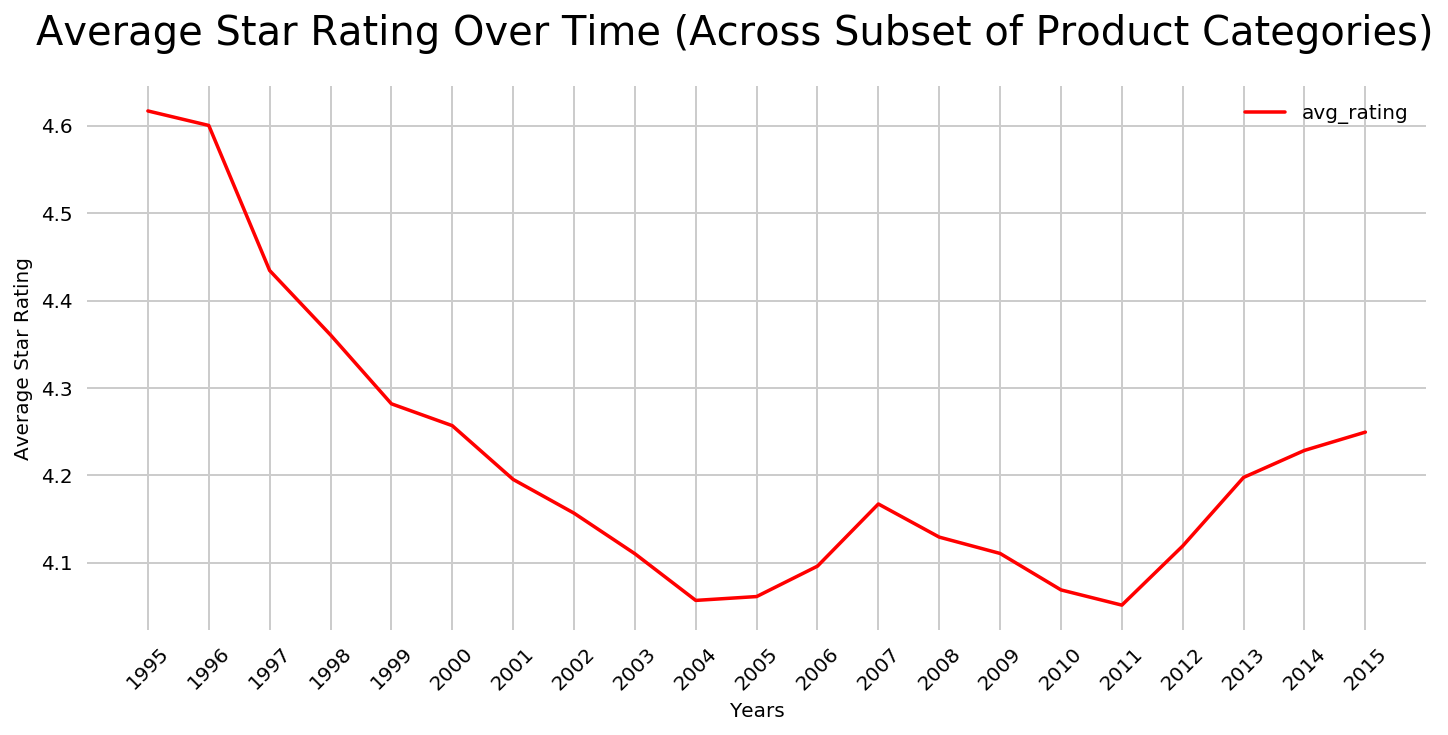

In [69]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Over Time (Across Subset of Product Categories)')

ax = plt.gca()
#ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df['year'].unique())

df.plot(kind='line',x='year',y='avg_rating', color='red', ax=ax)

#plt.xticks(range(1995, 2016, 1))
#plt.yticks(range(0,6,1))
plt.xlabel('Years')
plt.ylabel('Average Star Rating')
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-06.png"  width="90%" align="left">

## Average Star Rating Per Product Categories Across Time

In [70]:
# SQL statement 
statement = """
SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM {}.{}
GROUP BY product_category, year
ORDER BY year 
""".format(database_name, table_name)

print(statement)


SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category, year
ORDER BY year 



In [71]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,year,avg_rating_category
0,Books,1995,4.6111
1,Video,1995,5.0000
2,Music,1995,5.0000
3,Music,1996,4.7500
4,Video DVD,1996,4.3333
5,Video,1996,3.8333
6,Books,1996,4.6024
7,Sports,1997,4.0000
8,Video DVD,1997,4.7500
9,Books,1997,4.4339


## Visualization

In [72]:
def plot_categories(df):
    df_categories = df['product_category'].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df['product_category'] == category]
        df_plot.plot(kind='line',x='year',y='avg_rating_category', c=np.random.rand(3,), ax=ax, label=category)

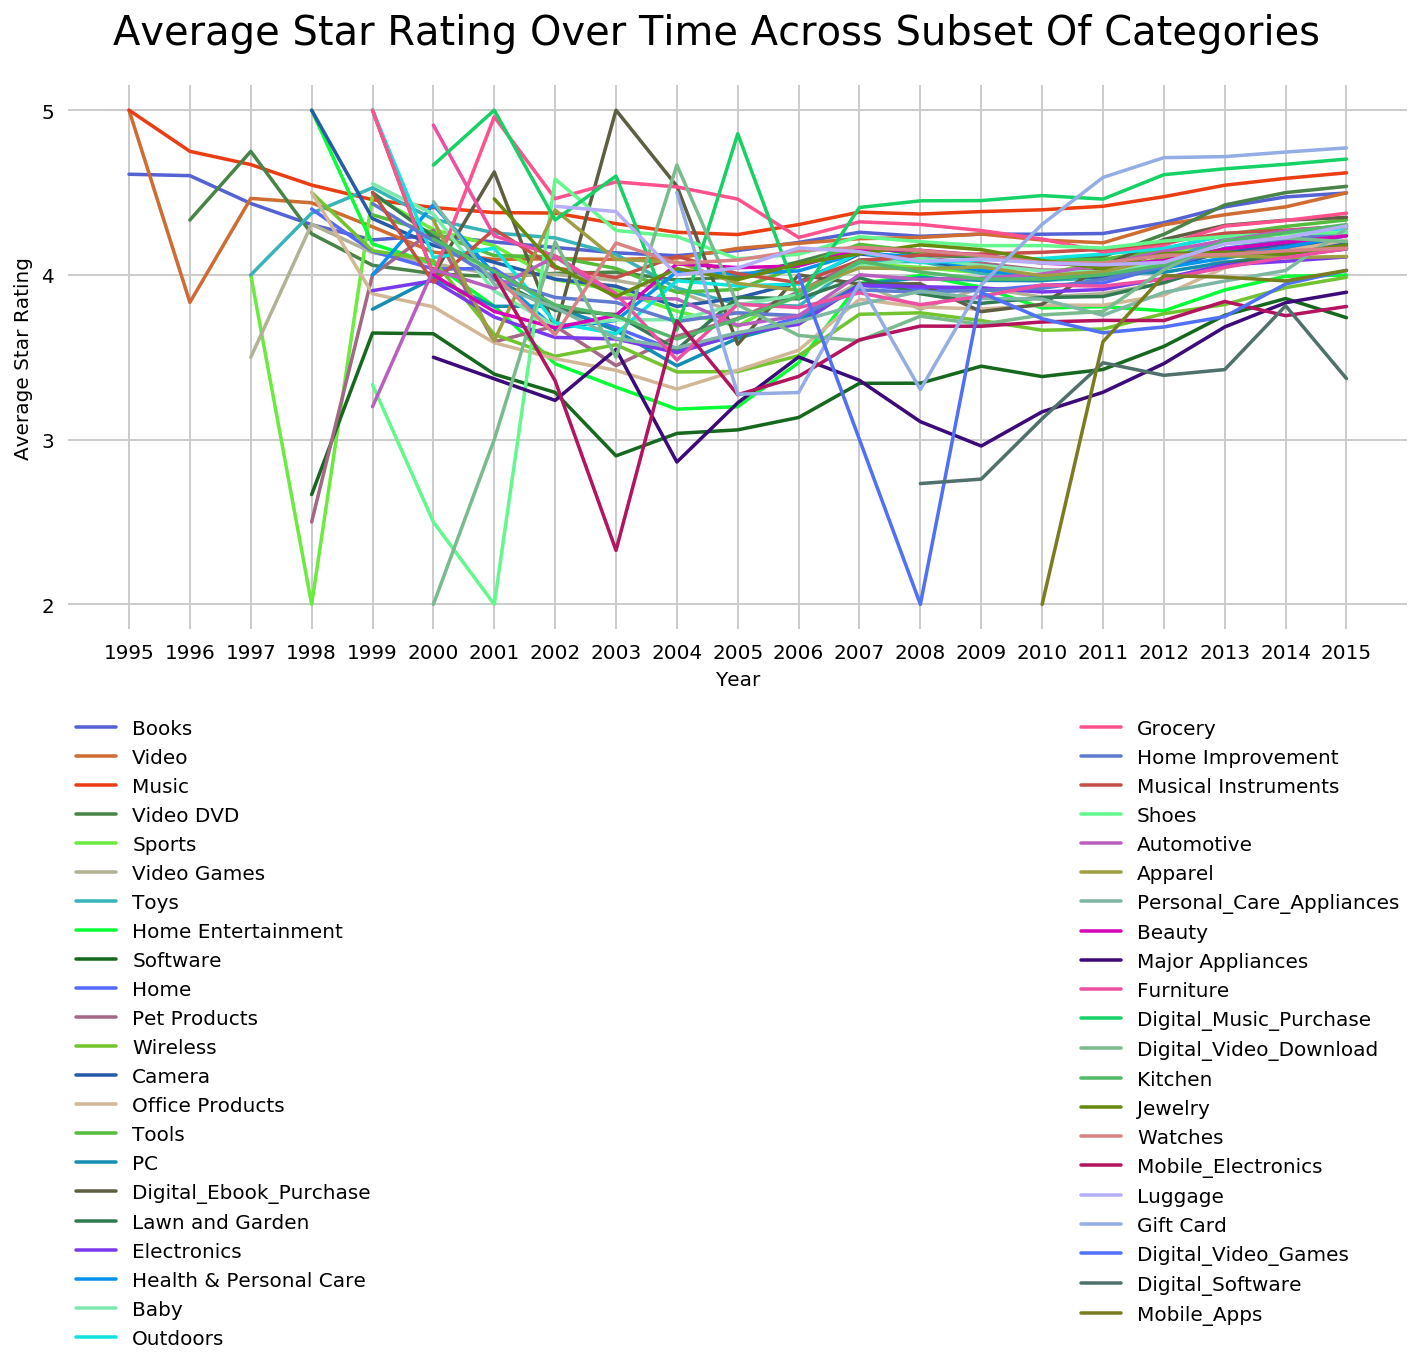

In [73]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Over Time Across Subset Of Categories')
           
ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df['year'].unique())

plot_categories(df)

plt.xlabel('Year')
plt.ylabel('Average Star Rating')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories, you would see the following visualization:

<img src="img/average_rating_category_all_data.png"  width="90%" align="left">

# 7. Which Star Ratings (1-5) are Most Helpful?

In [74]:
# SQL statement 
statement = """
SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM {}.{}
GROUP BY  star_rating
ORDER BY  star_rating ASC
""".format(database_name, table_name)

print(statement)


SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating ASC



In [75]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,star_rating,avg_helpful_votes
0,1,3.684641
1,2,2.506635
2,3,2.048090
3,4,1.678697
4,5,1.672698


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_helpful_all.png"  width="25%" align="left">

## Visualization for a Subset of Product Categories

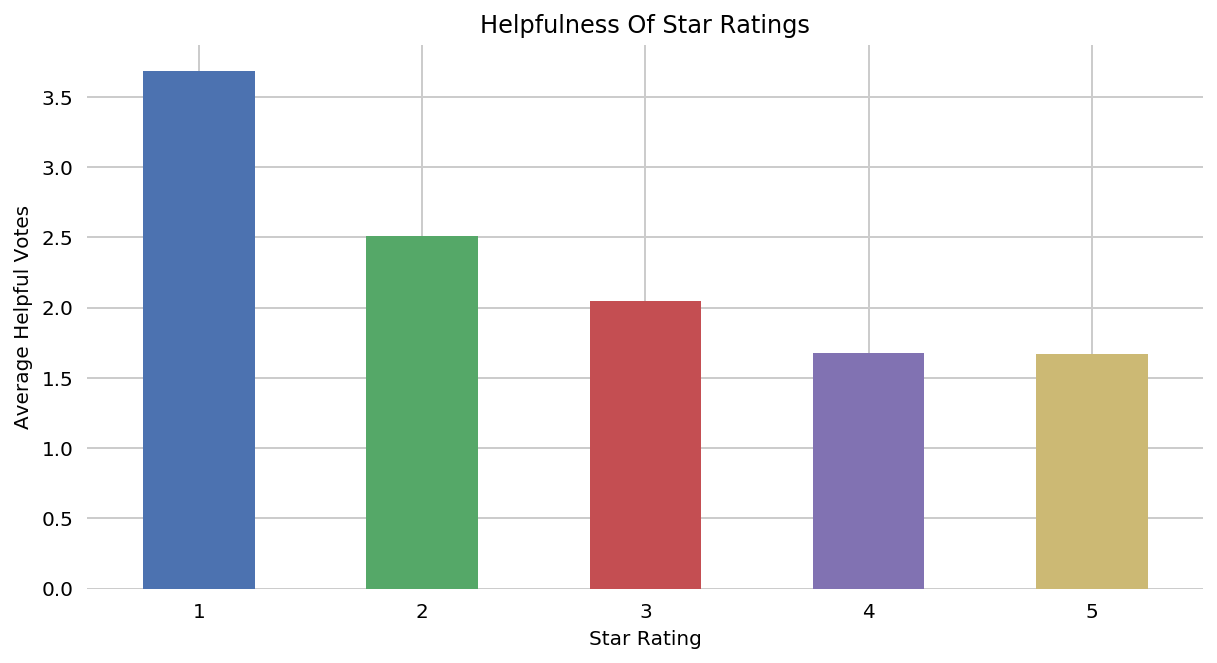

In [76]:
chart = df.plot.bar(x='star_rating', y='avg_helpful_votes', rot='0', figsize=(10,5), title='Helpfulness Of Star Ratings', legend=False )

plt.xlabel('Star Rating')
plt.ylabel('Average Helpful Votes')

# chart.get_figure().savefig('helpful-votes.png', dpi=300)
plt.show(chart)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-08.png"  width="70%" align="left">

# 8. Which Products have Most Helpful Reviews?  How Long are the Most Helpful Reviews?

In [ ]:
# SQL statement 
statement = """
SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM {}.{}
ORDER BY helpful_votes DESC LIMIT 10 
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/most_helpful_all.png"  width="90%" align="left">

# 9. What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?

In [ ]:
# SQL statement 
statement = """
SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
FROM (
  SELECT count(*) AS positive_review_count
  FROM {}.{}
  WHERE star_rating >= 4
), (
  SELECT count(*) AS negative_review_count
  FROM {}.{}
  WHERE star_rating < 4
)
""".format(database_name, table_name, database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/ratio_all.png"  width="25%" align="left">

# 10. Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product?  What Was Their Average Star Rating for Each Product?

In [ ]:
# SQL statement 
statement = """
SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM dsoaws.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5
""".format(database_name, table_name)

print(statement)

In [ ]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

## Result for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:
  
<img src="img/athena-abuse-all.png"  width="80%" align="left">